In [113]:
import credentials as cr
import SQL_requests as rq
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from spotify_api import Spotify_api
from db_connect import Db_connect
from recommendation_system import Recommendation

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Application parameters

In [2]:
# redirect_uri = 'http://localhost/'
data_path = cr.DATA_PATH

sp = Spotify_api()
db = Db_connect()
rc = Recommendation()

## Get datas using Spotify API  
I get my personnal spotify datas using spotify api and spotify_api.py class. The Pandas dataframes created are converted into csv files which will be used to create the sqlite database.

In [3]:
playlists_df = sp.get_playlists_with_tracks()

features_df = sp.get_playlist_features(playlists_df)
features_df.drop_duplicates(inplace=True)

tracks_df = sp.get_tracks(features_df)

contains_df = sp.get_contains(playlists_df)

playlists_df.to_csv(data_path + 'playlists.csv', encoding='utf-8')
features_df.to_csv(data_path + 'features.csv', encoding='utf-8')
tracks_df.to_csv(data_path + 'tracks.csv', encoding='utf-8')
contains_df.to_csv(data_path + 'contains.csv', encoding='utf-8', index=False)

Found playlists :  28
Pop/rock kings & queens
Autoportrait
Arcades & Neons
(RPG) Leon Petersen - Don't Piss Me Off
Feel good
(RPG) Scarface - Heavy Dirty Soul
Girl Power
Alternative/Psychedelic
Musique classique
(RPG) Ashton Butler - Punkin' Shakespeare
Badass Metal
(RPG) Spooky Unicorns - Rock'N Monsters
Old Time Rock'N Roll (Kurty's playlist)
Skate It !
Favoris
Horror Circus
Ballads & Slows
(RPG) Robyn Thorn - Rockin' Girl
Top 30
(RPG) Kurt Hayward - Punk Ass
(RPG) Zak Winterscar - Broken Soldier
Accoustic
Modern Pop/Rock
Classic Rock
Ol'Retro Mood (50/60's)
Deadshot
Red Hood
Nightwing


## DataBase connect and creation

Create the SQLite database, create or update the tables with spotify datas (playlist, feature, track).

In [13]:
db.init_connection()
db.create_tables([rq.CREATE_PLAYLIST, rq.CREATE_TRACK, rq.CREATE_TRACK_FEATURES, rq.CREATE_CONTAINS])
db.insert_data(rq.INSERT_PLAYLISTS, data_path + 'playlists.csv')
db.insert_data(rq.INSERT_TRACKS_FEATURES, data_path + 'features.csv')
db.insert_data(rq.INSERT_TRACKS, data_path + 'tracks.csv')
db.insert_data(rq.INSERT_CONTAINS, data_path + 'contains.csv')
db.close_connection()

## Developping the algorithm

I start by getting the 'Top 30' (6AsIwsN6mH7dQSChLsqSlY) playlist from the database, which will be used to developp and test the algorithm.  
Let's get the first try and view the results.

In [3]:
db.init_connection()
top_30_titles = pd.read_sql_query(rq.SELECT_PLAYLIST_TITLES + "'6AsIwsN6mH7dQSChLsqSlY'", db.connector).set_index('id')
track_titles = pd.read_sql_query(rq.SELECT_TRACKS_TITLES, db.connector).set_index('id')
track_features = pd.read_sql_query(rq.SELECT_TRACKS_FEATURES, db.connector).set_index('id')
db.close_connection()

### Vizualisation of the targetted playlist :

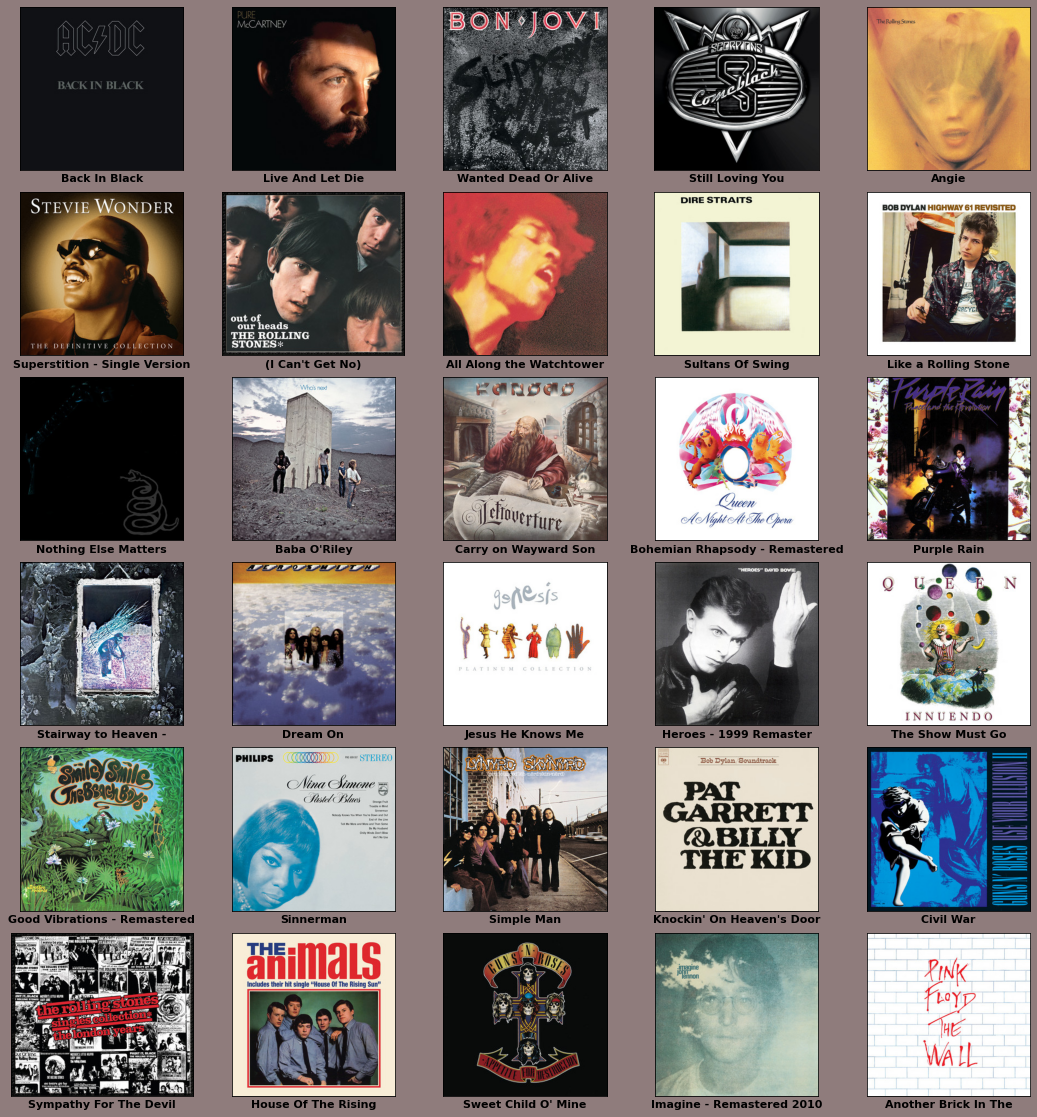

In [5]:
rc.visualize_cover(top_30_titles)

### Content-Based Recommender

### FIrst model using nearest neighbors

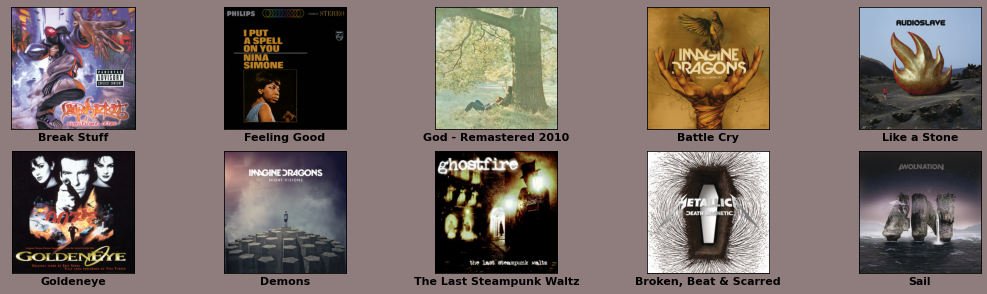

In [138]:
playlist, nonplaylist = rc.generate_playlist_nonplaylist(track_features, top_30_titles)

recommendation, recommendation_features = rc.get_recommendations(playlist, nonplaylist, track_features, track_titles)

rc.visualize_cover(recommendation)

##### Same model with data processing

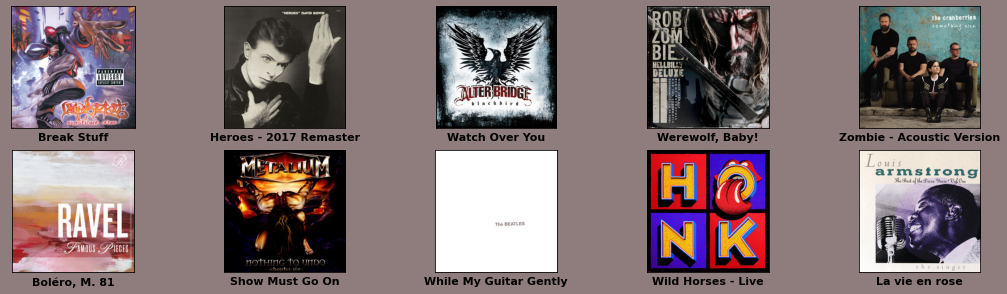

In [4]:
track_features_processed = rc.process_data(track_features)

playlist, nonplaylist = rc.generate_playlist_nonplaylist(track_features_processed, top_30_titles)
playlist_sum = playlist.sum(axis = 0)

recommendation, recommendation_features = rc.get_recommendations_processed(playlist, nonplaylist, track_features_processed, track_titles)

rc.visualize_cover(recommendation)

In [5]:
display(recommendation)

distance  weight  \
key                                        
5cZqsjVs6MevCnAkasbEOX  0.000002       1   
7Jh1bpe76CNTCgdgAdBw4Z  0.000005       1   
7kxfWvj6u9oWQ5C36kMtGb  0.000006       1   
7fv6wqJX3Mnu7z1dj7i0Ca  0.000007       1   
1qylvO4iCIZZcqc4TqSjTZ  0.000007       1   
0CDNVJ4YiK3XSi9JzUfZRD  0.000007       1   
10CCpSf5fLloewPH7YTh8t  0.000008       1   
389QX9Q1eUOEZ19vtzzI9O  0.000008       1   
4qWfbU8r7N87Enp19oMF62  0.000008       2   
1UH4viviUjZnS9aWgPGrk0  0.000009       1   

                                                                  name  \
key                                                                      
5cZqsjVs6MevCnAkasbEOX                                     Break Stuff   
7Jh1bpe76CNTCgdgAdBw4Z                          Heroes - 2017 Remaster   
7kxfWvj6u9oWQ5C36kMtGb                                  Watch Over You   
7fv6wqJX3Mnu7z1dj7i0Ca                                 Werewolf, Baby!   
1qylvO4iCIZZcqc4TqSjTZ                       Zombie - Acoustic Version   
0CDNVJ4YiK3XSi9JzUfZRD                                   Boléro, M. 81   
10CCpSf5fLloewPH7YTh8t                                 Show Must Go On   
389QX9Q1eUOEZ19vtzzI9O  While My Guitar Gently Weeps - Remastered 2009   
4qWfbU8r7N87Enp19oMF62            Wild Horses - Live At London Stadium   
1UH4viviUjZnS9aWgPGrk0                 La vie en rose - Single Version   

                                                                album_img  
key                                                                        
5cZqsjVs6MevCnAkasbEOX  https://i.scdn.co/image/ab67616d00001e02378378...  
7Jh1bpe76CNTCgdgAdBw4Z  https://i.scdn.co/image/ab67616d00001e02bc1c63...  
7kxfWvj6u9oWQ5C36kMtGb  https://i.scdn.co/image/ab67616d00001e0233fe38...  
7fv6wqJX3Mnu7z1dj7i0Ca  https://i.scdn.co/image/ab67616d00001e02985d72...  
1qylvO4iCIZZcqc4TqSjTZ  https://i.scdn.co/image/ab67616d00001e02d28b05...  
0CDNVJ4YiK3XSi9JzUfZRD  https://i.scdn.co/image/ab67616d00001e027c21fe...  
10CCpSf5fLloewPH7YTh8t  https://i.scdn.co/image/ab67616d00001e026fa613...  
389QX9Q1eUOEZ19vtzzI9O  https://i.scdn.co/image/ab67616d00001e024ce8b4...  
4qWfbU8r7N87Enp19oMF62  https://i.scdn.co/image/ab67616d00001e02b027df...  
1UH4viviUjZnS9aWgPGrk0  https://i.scdn.co/image/ab67616d00001e026555e6...

In [8]:
cosine = rc.get_cosine_similarity(playlist, recommendation_features, track_titles)
display(cosine)
print("MEAN COSINE SIMILARITY : ", cosine.sim_mean.mean())

sim  \
id                                                                          
5cZqsjVs6MevCnAkasbEOX  [[0.7499999908279483, 0.9999999873477543, 0.99...   
7Jh1bpe76CNTCgdgAdBw4Z  [[0.750000004259868, 0.7500000073841926, 0.750...   
7kxfWvj6u9oWQ5C36kMtGb  [[0.7499999914755284, 0.7500000079370629, 0.75...   
7fv6wqJX3Mnu7z1dj7i0Ca  [[0.7500000002856415, 0.7500000108025013, 0.75...   
1qylvO4iCIZZcqc4TqSjTZ  [[0.5000000105245387, 0.5000000185525159, 0.50...   
0CDNVJ4YiK3XSi9JzUfZRD  [[0.5000000053433642, 0.5000000059565932, 0.50...   
10CCpSf5fLloewPH7YTh8t  [[0.5000000086433191, 0.500000027056985, 0.500...   
389QX9Q1eUOEZ19vtzzI9O  [[0.5000000109599473, 0.5000000209587677, 0.50...   
4qWfbU8r7N87Enp19oMF62  [[0.7500000041747895, 0.75000000634861, 0.7500...   
1UH4viviUjZnS9aWgPGrk0  [[0.7500000028382229, 0.7500000087532648, 0.75...   

                        sim_mean  \
id                                 
5cZqsjVs6MevCnAkasbEOX  0.675000   
7Jh1bpe76CNTCgdgAdBw4Z  0.691667   
7kxfWvj6u9oWQ5C36kMtGb  0.691667   
7fv6wqJX3Mnu7z1dj7i0Ca  0.691667   
1qylvO4iCIZZcqc4TqSjTZ  0.575000   
0CDNVJ4YiK3XSi9JzUfZRD  0.466667   
10CCpSf5fLloewPH7YTh8t  0.583333   
389QX9Q1eUOEZ19vtzzI9O  0.575000   
4qWfbU8r7N87Enp19oMF62  0.691667   
1UH4viviUjZnS9aWgPGrk0  0.683333   

                                                                  name  \
id                                                                       
5cZqsjVs6MevCnAkasbEOX                                     Break Stuff   
7Jh1bpe76CNTCgdgAdBw4Z                          Heroes - 2017 Remaster   
7kxfWvj6u9oWQ5C36kMtGb                                  Watch Over You   
7fv6wqJX3Mnu7z1dj7i0Ca                                 Werewolf, Baby!   
1qylvO4iCIZZcqc4TqSjTZ                       Zombie - Acoustic Version   
0CDNVJ4YiK3XSi9JzUfZRD                                   Boléro, M. 81   
10CCpSf5fLloewPH7YTh8t                                 Show Must Go On   
389QX9Q1eUOEZ19vtzzI9O  While My Guitar Gently Weeps - Remastered 2009   
4qWfbU8r7N87Enp19oMF62            Wild Horses - Live At London Stadium   
1UH4viviUjZnS9aWgPGrk0                 La vie en rose - Single Version   

                                                                album_img  
id                                                                         
5cZqsjVs6MevCnAkasbEOX  https://i.scdn.co/image/ab67616d00001e02378378...  
7Jh1bpe76CNTCgdgAdBw4Z  https://i.scdn.co/image/ab67616d00001e02bc1c63...  
7kxfWvj6u9oWQ5C36kMtGb  https://i.scdn.co/image/ab67616d00001e0233fe38...  
7fv6wqJX3Mnu7z1dj7i0Ca  https://i.scdn.co/image/ab67616d00001e02985d72...  
1qylvO4iCIZZcqc4TqSjTZ  https://i.scdn.co/image/ab67616d00001e02d28b05...  
0CDNVJ4YiK3XSi9JzUfZRD  https://i.scdn.co/image/ab67616d00001e027c21fe...  
10CCpSf5fLloewPH7YTh8t  https://i.scdn.co/image/ab67616d00001e026fa613...  
389QX9Q1eUOEZ19vtzzI9O  https://i.scdn.co/image/ab67616d00001e024ce8b4...  
4qWfbU8r7N87Enp19oMF62  https://i.scdn.co/image/ab67616d00001e02b027df...  
1UH4viviUjZnS9aWgPGrk0  https://i.scdn.co/image/ab67616d00001e026555e6...

MEAN COSINE SIMILARITY :  0.6325000130394612


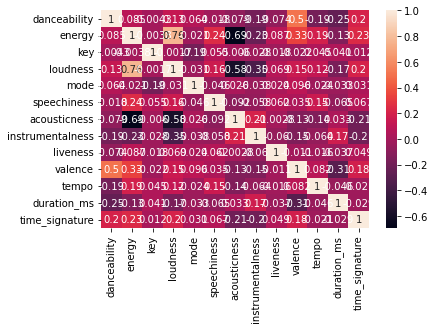

In [12]:
matrix = track_features.corr()
sn.heatmap(matrix, annot=True)
plt.show()

##### RandomizedSearchCV // GridSearch

### Second model using cosine similarity

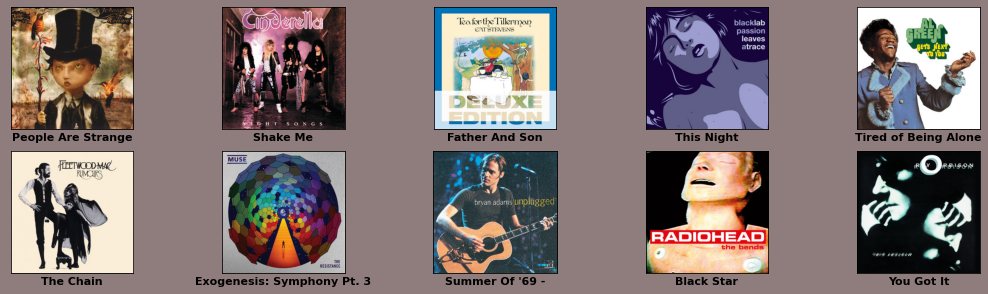

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

track_features_processed = rc.process_data(track_features)

playlist, nonplaylist = rc.generate_playlist_nonplaylist(track_features_processed, top_30_titles)
playlist_sum = playlist.sum(axis = 0)

nonplaylist_copy = nonplaylist.copy()

nonplaylist_copy['sim'] = cosine_similarity(nonplaylist.values, playlist_sum.values.reshape(1, -1))[:,0]

recommendation = nonplaylist_copy.sort_values('sim',ascending = False).head(10)
recommendation = recommendation.merge(track_titles, left_index=True, right_index=True)

recommendation.head()

rc.visualize_cover(recommendation)

In [8]:
recommendation.head()

danceability    energy  loudness  speechiness  \
id                                                                      
6YAqup47jDR6QDYgILHlVX      0.000052  0.000052       0.0     0.000049   
1Qjpl8Kav6rrO92ZuG0OK8      0.000056  0.000057       0.0     0.000054   
2tbdjsdJ9xtyunKnZBkGxF      0.000054  0.000054       0.0     0.000052   
39zkdU2RwrLdgitEEOrGcZ      0.000040  0.000039       0.0     0.000037   
10vkYRKw6Jjr7try1ir50G      0.000054  0.000052       0.0     0.000050   

                        acousticness  instrumentalness  liveness   valence  \
id                                                                           
6YAqup47jDR6QDYgILHlVX      0.000053          0.000050  0.000049  0.000051   
1Qjpl8Kav6rrO92ZuG0OK8      0.000053          0.000053  0.000054  0.000056   
2tbdjsdJ9xtyunKnZBkGxF      0.000055          0.000052  0.000052  0.000054   
39zkdU2RwrLdgitEEOrGcZ      0.000037          0.000038  0.000037  0.000039   
10vkYRKw6Jjr7try1ir50G      0.000052          0.000050  0.000050  0.000053   

                           tempo  duration_ms  ...  key_10  key_11  \
id                                             ...                   
6YAqup47jDR6QDYgILHlVX  0.000649          1.0  ...       0       0   
1Qjpl8Kav6rrO92ZuG0OK8  0.000650          1.0  ...       0       0   
2tbdjsdJ9xtyunKnZBkGxF  0.000668          1.0  ...       0       0   
39zkdU2RwrLdgitEEOrGcZ  0.000667          1.0  ...       0       0   
10vkYRKw6Jjr7try1ir50G  0.000618          1.0  ...       0       0   

                        time_signature_0  time_signature_1  time_signature_3  \
id                                                                             
6YAqup47jDR6QDYgILHlVX                 0                 0                 0   
1Qjpl8Kav6rrO92ZuG0OK8                 0                 0                 0   
2tbdjsdJ9xtyunKnZBkGxF                 0                 0                 0   
39zkdU2RwrLdgitEEOrGcZ                 0                 0                 0   
10vkYRKw6Jjr7try1ir50G                 0                 0                 0   

                        time_signature_4  time_signature_5       sim  \
id                                                                     
6YAqup47jDR6QDYgILHlVX                 1                 0  0.867222   
1Qjpl8Kav6rrO92ZuG0OK8                 1                 0  0.867222   
2tbdjsdJ9xtyunKnZBkGxF                 1                 0  0.867222   
39zkdU2RwrLdgitEEOrGcZ                 1                 0  0.867222   
10vkYRKw6Jjr7try1ir50G                 1                 0  0.867222   

                                        name  \
id                                             
6YAqup47jDR6QDYgILHlVX    People Are Strange   
1Qjpl8Kav6rrO92ZuG0OK8              Shake Me   
2tbdjsdJ9xtyunKnZBkGxF        Father And Son   
39zkdU2RwrLdgitEEOrGcZ            This Night   
10vkYRKw6Jjr7try1ir50G  Tired of Being Alone   

                                                                album_img  
id                                                                         
6YAqup47jDR6QDYgILHlVX  https://i.scdn.co/image/ab67616d00001e02215dfd...  
1Qjpl8Kav6rrO92ZuG0OK8  https://i.scdn.co/image/ab67616d00001e028e5911...  
2tbdjsdJ9xtyunKnZBkGxF  https://i.scdn.co/image/ab67616d00001e024a45ab...  
39zkdU2RwrLdgitEEOrGcZ  https://i.scdn.co/image/ab67616d00001e026a417f...  
10vkYRKw6Jjr7try1ir50G  https://i.scdn.co/image/ab67616d00001e02fec6bb...  

[5 rows x 32 columns]

### Using classification

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

playlist, nonplaylist = rc.generate_playlist_nonplaylist(track_features_processed, top_30_titles)

train_test_dataset = track_features_processed.copy()
train_test_dataset['playlist'] = train_test_dataset.apply(lambda x: int(x.name in top_30_titles.index), axis=1)

classifier_data = train_test_dataset.copy()
classifier_data = classifier_data.sort_values(['playlist'], ascending=False).head(100)

classifier_target = classifier_data['playlist']

classifier_data = classifier_data.drop('loudness',axis = 1)
classifier_data = classifier_data.drop('playlist',axis = 1)

X_train, X_test, y_train, y_test = train_test_split(classifier_data, classifier_target, test_size=0.3) # 70% training and 30% test

Accuracy: 0.8


##### kNNClassifier

In [161]:
knn = KNeighborsClassifier(n_neighbors=9)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8


C:\Users\audre\anaconda3\envs\spotify2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\audre\anaconda3\envs\spotify2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\audre\anaconda3\envs\spotify2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\audre\anaconda3\envs\spotify2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\audre\anaconda3\envs\spotify2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


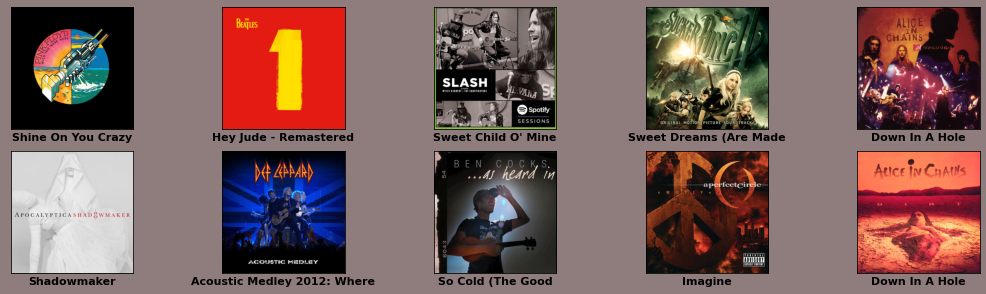

In [158]:
recommendation = nonplaylist.copy()
recommendation = recommendation.drop('loudness',axis = 1)

recommendation['predict'] = recommendation.apply(lambda x: knn.predict([x])[0], axis=1)
recommendation['proba'] = recommendation.loc[:, recommendation.columns != 'predict'].apply(lambda x: knn.predict_proba([x])[0].max(), axis=1)

recommendation = recommendation[recommendation['predict']==1]
recommendation = recommendation.sort_values('proba', ascending=False).head(10)

recommendation = recommendation.merge(track_titles, left_index=True, right_index=True)
rc.visualize_cover(recommendation)

##### Finding the right K

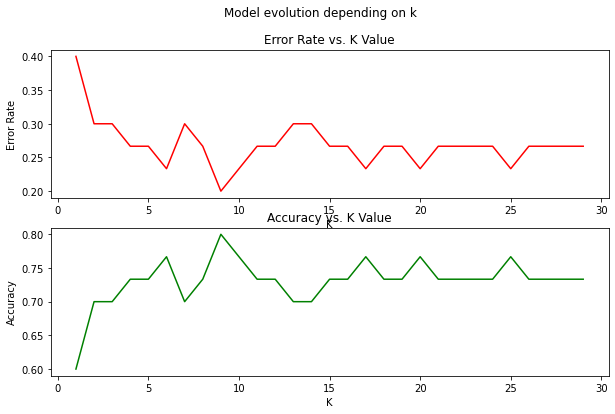

In [155]:
error_rate_knn = []
accuracy_knn = []

for i in range(1,30):

    # kNN
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)

    error_rate_knn.append(np.mean(y_pred != y_test))
    accuracy_knn.append(metrics.accuracy_score(y_test, y_pred))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6))
fig.suptitle('Model evolution depending on k')

ax1.plot(range(1,30),error_rate_knn,color='red')
ax1.set_title('Error Rate vs. K Value')
ax1.set_xlabel('K')
ax1.set_ylabel('Error Rate')

ax2.plot(range(1,30),accuracy_knn,color='green')
ax2.set_title('Accuracy vs. K Value')
ax2.set_xlabel('K')
ax2.set_ylabel('Accuracy')

plt.show()

##### KMeans

In [175]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2, random_state=0) #random_state=i
kmeans.fit(X_train, y_train)
y_pred = kmeans.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6666666666666666


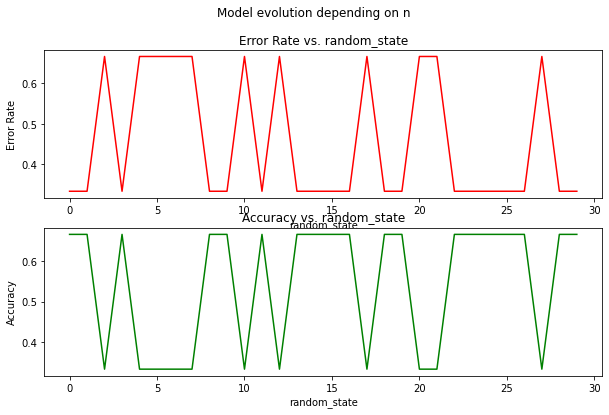

In [178]:
error_rate = []
accuracy = []

for i in range(0,30):

    kmeans = KMeans(n_clusters=2, random_state=i)
    kmeans.fit(X_train, y_train)
    y_pred = kmeans.predict(X_test)

    error_rate.append(np.mean(y_pred != y_test))
    accuracy.append(metrics.accuracy_score(y_test, y_pred))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6))
fig.suptitle('Model evolution depending on n')

ax1.plot(range(0,30),error_rate,color='red')
ax1.set_title('Error Rate vs. random_state')
ax1.set_xlabel('random_state')
ax1.set_ylabel('Error Rate')

ax2.plot(range(0,30),accuracy,color='green')
ax2.set_title('Accuracy vs. random_state')
ax2.set_xlabel('random_state')
ax2.set_ylabel('Accuracy')

plt.show()